In [1]:
%load_ext autoreload
%autoreload 2

# change directory to repo root, and verify
%cd '../'
!pwd

/cephyr/users/markpett/Alvis/satellite_poverty_prediction
/cephyr/users/markpett/Alvis/satellite_poverty_prediction


In [2]:
import numpy as np
import pandas as pd
import argparse
import os
import scipy.spatial
import time

data_dir = '/cephyr/NOBACKUP/groups/globalpoverty1/data'
fold_config = 'ooc'
model_fold = 'A'

In [3]:
def get_data(data_dir, fold_config, model_fold, df):

    # Get path
    hist_dir = os.path.join(data_dir, 'hists', fold_config, model_fold, '{}')

    X_list = []
    y_list = []
    ix_list = []
    group_list = []

    for i, fold in enumerate('ABCDE'):
        fold_dir = hist_dir.format(fold)
        fold_X = np.load(os.path.join(fold_dir, 'hists.npy'))
        X_list.append(fold_X)
        fold_y = np.load(os.path.join(fold_dir, 'labels.npy')).flatten()
        y_list.append(fold_y)
        fold_ix = np.load(os.path.join(fold_dir, 'indices.npy'))
        ix_list.append(fold_ix)
        if fold_config == 'ooc':
            fold_countries = df.loc[fold_ix, 'country'].values
            group_list.append(fold_countries)
            if fold == model_fold:
                test_groups = np.unique(fold_countries)
        else:
            group_list.append([i] * len(fold_y))
            if fold == model_fold:
                test_groups = [i]

    img_hists = np.concatenate(X_list)
    features = img_hists.reshape(len(img_hists), -1)
    labels = np.concatenate(y_list)
    indices = np.concatenate(ix_list)
    group_labels = np.concatenate(group_list)

    return features, labels, indices, group_labels, test_groups

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'dhs_clusters.csv'), float_precision='high', index_col=False)

features, labels, indices, group_labels, test_groups = get_data(data_dir, fold_config, model_fold, df)
group_names = np.unique(group_labels)

N = len(labels)
assert len(features) == N
assert len(group_labels) == N

In [5]:
def get_dist_matrix(features, distance_metric='cityblock'):
    print('Pre-computing distance matrix...', end='')
    start = time.time()
    dists = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(features, metric=distance_metric)
    )
    elapsed = time.time() - start
    print(f' took {elapsed:.2f} seconds.')
    return dists

In [6]:
# dists = get_dist_matrix(features)
dists = np.load('/cephyr/NOBACKUP/groups/globalpoverty1/data/dists.npy')

In [10]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.spatial
import sklearn
from sklearn.neighbors import KNeighborsRegressor

def train_knn_logo_opt(dists, features, labels, group_labels, cv_groups, test_groups,
                       weights=None, plot=True, group_names=None):
    '''Leave-one-group-out cross-validated training of a KNN model.
    Similar to train_knn_logo(), but uses a pre-computed distance matrix.
    Args
    - dists: np.array, shape [N, N], precomputed distance matrix
    - features: np.array, shape [N, D]
    - labels: np.array, shape [N]
    - group_labels: np.array, shape [N], type np.int32
    - cv_groups: list of int, labels of groups to use for LOGO-CV
    - test_groups: list of int, labels of groups to test on
    - weights: np.array, shape [N]
    - plot: bool, whether to plot MSE as a function of k
    - group_names: list of str, names of the groups, only used when plotting
    Returns
    - test_preds: np.array, predictions on indices from test_groups
    '''
    cv_indices = np.isin(group_labels, cv_groups).nonzero()[0]
    test_indices = np.isin(group_labels, test_groups).nonzero()[0]

    dists_cv = dists[np.ix_(cv_indices, cv_indices)]
    X = features[cv_indices]
    y = labels[cv_indices]
    groups = group_labels[cv_indices]
    w = None if weights is None else weights[cv_indices]

    ks = 2 ** np.arange(0, 11)  # 1 to 1024
    preds = np.ones([len(ks), len(cv_indices)], dtype=np.float64) * np.nan
    group_mses = np.ones([len(ks), len(cv_groups)], dtype=np.float64) * np.nan
    leftout_group_labels = np.zeros(len(cv_groups), dtype=groups.dtype)
    logo = sklearn.model_selection.LeaveOneGroupOut()

    for g, (train_indices, val_indices) in enumerate(logo.split(X, groups=groups)):
        leftout_group_labels[g] = groups[val_indices[0]]

        train_X, train_y = X[train_indices], y[train_indices]
        val_y = y[val_indices]
        val_w = None if w is None else w[val_indices]

        # assign each unique input training value the same training label
        if len(train_X.shape) == 1:  # scalars
            u = np.unique(train_X)
            new_train_y = np.zeros_like(train_y)
            for value in u:
                mask = (train_X == value)
                new_train_y[mask] = np.mean(train_y[mask])
            train_y = new_train_y

        nearest_indices = np.argsort(dists_cv[np.ix_(val_indices, train_indices)], axis=1)

        for i, k in enumerate(ks):
            if len(train_indices) < k:
                break

            val_preds = np.mean(train_y[nearest_indices[:, :k]], axis=1)
            preds[i, val_indices] = val_preds
            group_mses[i, g] = np.average((val_preds - val_y) ** 2, weights=val_w)

    mses = np.average((preds - y) ** 2, axis=1, weights=w)  # shape [K]

    if plot:
        h = max(3, len(group_names) * 0.2)
        fig, ax = plt.subplots(1, 1, figsize=(h*2, h), constrained_layout=True)
        for g, group_label in enumerate(leftout_group_labels):
            ax.scatter(x=ks, y=group_mses[:, g], label=group_label,
                       c=[cm.tab20.colors[g % 20]])
        ax.plot(ks, mses, 'g-', label='Overall val mse')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Left-out Group')
        ax.set(xlabel='k', ylabel='mse')
        ax.set_xscale('log')
        ax.grid(True)
        if isinstance(plot, str):
            print(f'Saved KNN plot to {plot}')
            plt.savefig(plot)
        else:
            plt.show()

    best_k = ks[np.argmin(mses)]

    # assign each unique input training value the same training label
    if len(X.shape) == 1:  # scalars
        u = np.unique(X)
        new_y = np.zeros_like(y)
        for value in u:
            mask = (X == value)
            new_y[mask] = np.mean(y[mask])
        y = new_y

    nearest_indices = np.argsort(dists[np.ix_(test_indices, cv_indices)], axis=1)
    test_preds = np.mean(y[nearest_indices[:, :best_k]], axis=1)

    best_val_mse = np.min(mses)
    test_y = labels[test_indices]
    test_w = None if weights is None else weights[test_indices]
    test_mse = np.average((test_preds - test_y) ** 2, weights=test_w)
    print(f'best val mse: {best_val_mse:.3f}, best k: {best_k}, test mse: {test_mse:.3f}')
    return test_preds

In [11]:
save_plots = True

In [12]:
if save_plots:
    plot_dir = os.path.join(data_dir, 'knn_plots', fold_config)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

Group: burundi
best val mse: 0.023, best k: 32, test mse: 0.008
 took 232.63 seconds.
Group: egypt
best val mse: 0.017, best k: 64, test mse: 0.057
 took 211.48 seconds.
Group: niger
best val mse: 0.023, best k: 32, test mse: 0.020
 took 247.38 seconds.
Group: south_africa
best val mse: 0.022, best k: 32, test mse: 0.079
 took 939.12 seconds.
Group: zambia
best val mse: 0.023, best k: 32, test mse: 0.015
 took 2446.37 seconds.
 took 4076.98 seconds.


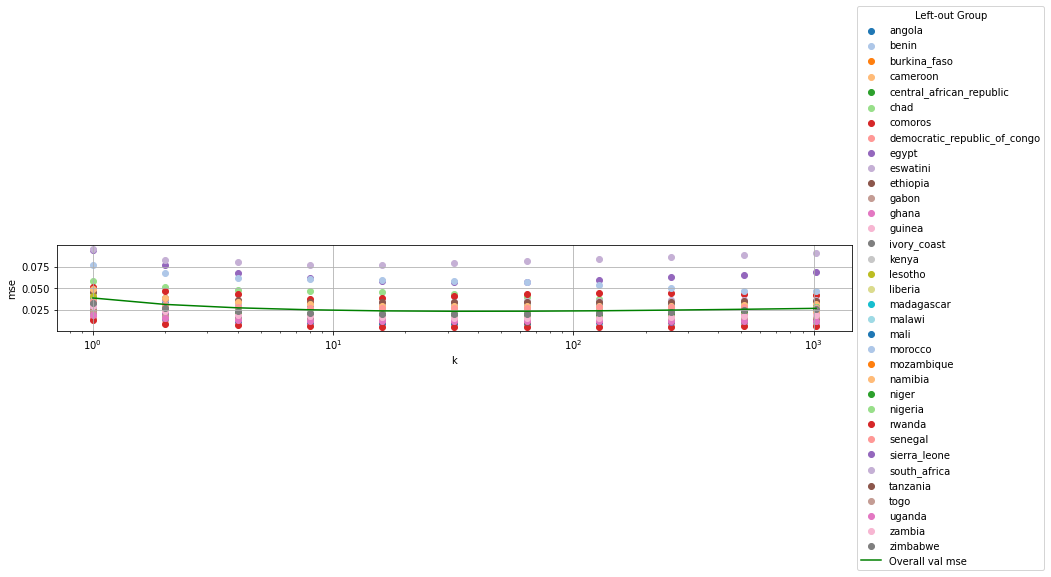

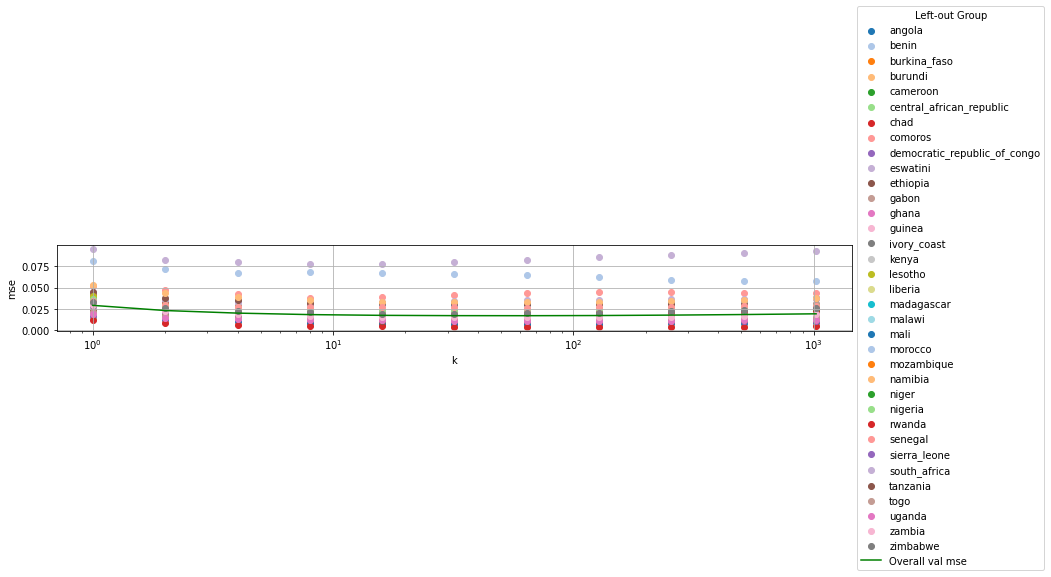

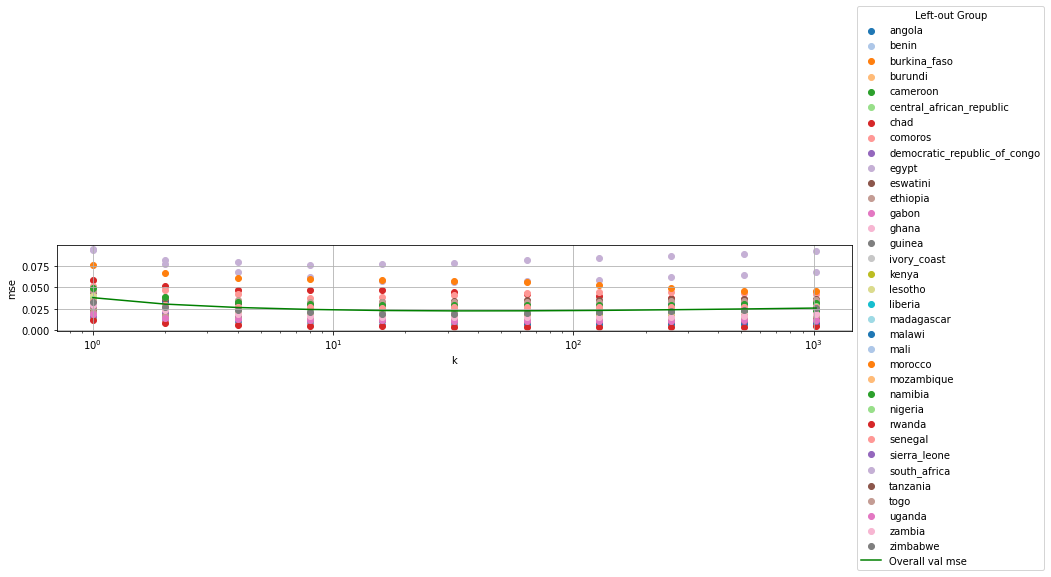

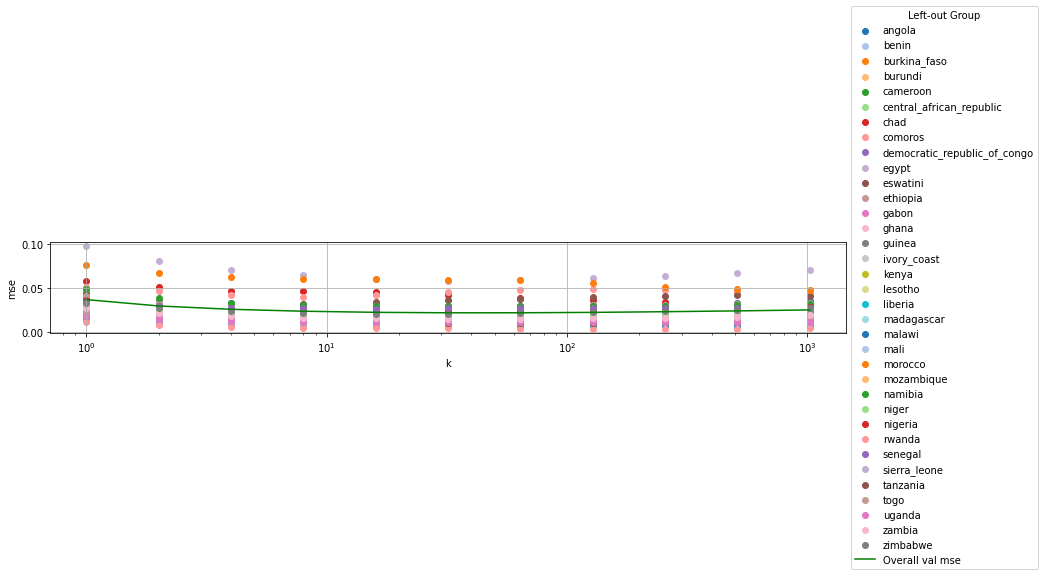

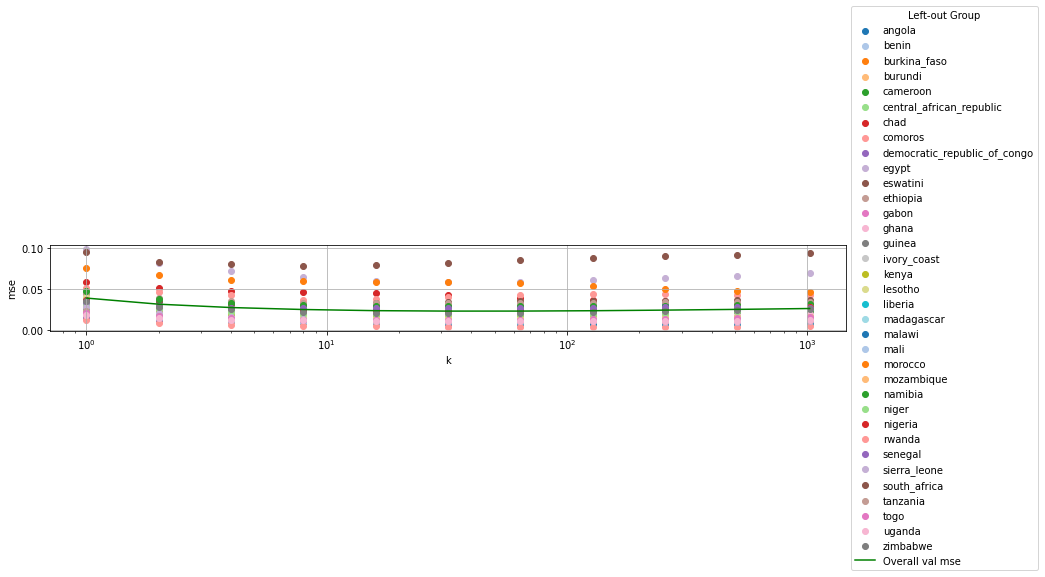

In [13]:
start = time.time()
test_preds = np.zeros_like(labels, dtype=np.float32)
for i, f in enumerate(test_groups):
    print('Group:', f)
    group_start = time.time()
    test_mask = (group_labels == f)
    test_indices = indices[test_mask]
    
    plot = os.path.join(plot_dir, f'{f}.png') if save_plots else None

    test_preds[test_indices] = train_knn_logo_opt(
        dists=dists,
        features=features,
        labels=labels,
        group_labels=group_labels,
        cv_groups=[x for x in group_names if x != f],
        test_groups=[f],
        weights=None,
        plot=plot,
        group_names=group_names)
    
    elapsed = time.time() - group_start
    print(f' took {elapsed:.2f} seconds.')
elapsed = time.time() - start
print(f' took {elapsed:.2f} seconds.')

In [14]:
print('Saving results...')
test_indices = indices[np.argwhere(np.isin(group_labels, test_groups)).ravel()]
result_df = pd.DataFrame({'x_i': test_preds[test_indices]}, index=test_indices)
result_df['fold'] = model_fold
result_df.to_csv(os.path.join(data_dir, 'hists', fold_config, model_fold, 'knn_preds.csv'), index=True)

Saving results...


## Försök

In [64]:
dists=dists
features=features
labels=labels
group_labels=group_labels
cv_groups=[x for x in group_names if x != f]
test_groups=[f]
group_names=group_names

In [76]:
print('dists:', dists)
print('features:', features)
print('labels:', labels)
print('group_labels:', group_labels)
print('cv_groups:', cv_groups)
print('test_groups:', test_groups)
print('group_names:', group_names)

dists: [[     0. 244612. 233348. ... 371480. 348444. 387792.]
 [244612.      0.  95540. ... 467198. 430738. 461590.]
 [233348.  95540.      0. ... 442130. 426524. 450448.]
 ...
 [371480. 467198. 442130. ...      0. 158342.  94520.]
 [348444. 430738. 426524. ... 158342.      0.  97830.]
 [387792. 461590. 450448. ...  94520.  97830.      0.]]
features: [[    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 ...
 [    0     1 12134 ...     0     0     0]
 [    0     0  5282 ...     0     0     0]
 [    0     0  7859 ...     0     0     0]]
labels: [[0.16717534]
 [0.62176615]
 [0.4730884 ]
 ...
 [0.15859506]
 [0.20253435]
 [0.19971375]]
group_labels: ['burundi' 'burundi' 'burundi' ... 'rwanda' 'rwanda' 'rwanda']
cv_groups: ['angola', 'benin', 'burkina_faso', 'cameroon', 'central_african_republic', 'chad', 'comoros', 'democratic_republic_of_congo', 'egypt', 'eswatini', 'ethiopia', 'gabon', 'ghana', 'guinea', 'ivory_co

In [ ]:
cv_indices = np.isin(group_labels, cv_groups).nonzero()[0]
test_indices = np.isin(group_labels, test_groups).nonzero()[0]

dists_cv = dists[np.ix_(cv_indices, cv_indices)]
X = features[cv_indices]
y = labels[cv_indices]
groups = group_labels[cv_indices]
w = None if weights is None else weights[cv_indices]

ks = 2 ** np.arange(0, 11)  # 1 to 1024
preds = np.ones([len(ks), len(cv_indices)], dtype=np.float64) * np.nan
group_mses = np.ones([len(ks), len(cv_groups)], dtype=np.float64) * np.nan
leftout_group_labels = np.zeros(len(cv_groups), dtype=np.int32)
logo = sklearn.model_selection.LeaveOneGroupOut()

In [68]:
dists_cv = dists[np.ix_(cv_indices, cv_indices)]
X = features[cv_indices]
y = labels[cv_indices]
groups = group_labels[cv_indices]

In [75]:
import sklearn.model_selection

ks = 2 ** np.arange(0, 11)  # 1 to 1024
preds = np.ones([len(ks), len(cv_indices)], dtype=np.float64) * np.nan
group_mses = np.ones([len(ks), len(cv_groups)], dtype=np.float64) * np.nan
leftout_group_labels = np.zeros(len(cv_groups), dtype=np.int32)
logo = sklearn.model_selection.LeaveOneGroupOut()

In [ ]:
for g, (train_indices, val_indices) in enumerate(logo.split(X, groups=groups)):
    leftout_group_labels[g] = groups[val_indices[0]]

    train_X, train_y = X[train_indices], y[train_indices]
    val_y = y[val_indices]

## slut försök

In [23]:
for g in group_list:
    print(np.unique(g))

['burundi' 'egypt' 'niger' 'south_africa' 'zambia']
['benin' 'gabon' 'liberia' 'mozambique' 'nigeria' 'uganda' 'zimbabwe']
['burkina_faso' 'cameroon' 'chad' 'comoros' 'lesotho' 'malawi' 'senegal'
 'togo']
['central_african_republic' 'democratic_republic_of_congo' 'ethiopia'
 'guinea' 'ivory_coast' 'mali' 'sierra_leone' 'tanzania']
['angola' 'eswatini' 'ghana' 'kenya' 'madagascar' 'morocco' 'namibia'
 'rwanda']


In [24]:
image_hists = np.concatenate(X_list)
labels = np.concatenate(y_list)
ix = np.concatenate(ix_list)
years = df.loc[ix, 'year'].values
group_labels = np.concatenate(group_list)

In [18]:
def split_nl_hist(image_hists, years):
    '''
    Args
    - image_hists: np.array, shape [nimages, C, nbins], last band is NIGHTLIGHTS
    - years: np.array, shape [nimages]
    Returns
    - image_hists_nl: np.array, shape [nimages, C+1, nbins]
        2nd-to-last band is DMSP, last band is VIIRS
    '''
    nimages, C, nbins = image_hists.shape
    image_hists_nl = np.zeros([nimages, C+1, nbins])
    dmsp_indices = np.where(years < 2012)[0]
    viirs_indices = np.where(years >= 2012)[0]
    dmsp_bands = np.arange(C)  # [0, 1, ..., C-1]
    viirs_bands = np.array(list(range(C-1)) + [C])  # [0, 1, ..., C-2, C]
    for indices, bands in [(dmsp_indices, dmsp_bands), (viirs_indices, viirs_bands)]:
        if np.sum(indices) == 0: continue
        image_hists_nl[indices[:, None], bands, :] = image_hists[indices]
    assert(np.any(image_hists_nl[dmsp_indices, -2:-1, :] > 0))
    assert(np.any(image_hists_nl[viirs_indices, -1:, :] > 0))
    return image_hists_nl

image_hists = split_nl_hist(image_hists, years)

In [19]:
from matplotlib import pyplot as plt

def plot_band_hists(band_hists, band_order, band_colors, bin_centers, xlabel,
                    ylabel, title, yscale='linear'):
    '''
    Args
    - band_hists: np.array, shape [C, nbins]
      - assumes DMSP and VIIRS each have their own band
    - band_order: list of str
    - band_colors: dict, band_name => matplotlib color
    - bin_centers: np.array, shape [nbins]
    - xlabel, ylabel, title: str
    - yscale: str, one of ['linear', 'log']
    '''
    fig, ax = plt.subplots(1, 1, figsize=[10, 4])
    nbands = band_hists.shape[0]
    for b in range(nbands):
        band_name = band_order[b]
        ax.plot(bin_centers, band_hists[b], label=band_name, color=band_colors[band_name])
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title, yscale=yscale)
    ax.grid(True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

In [25]:
# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'DMSP', 'VIIRS']
BAND_BIN_CENTERS = np.arange(0, 1.01, 0.01)

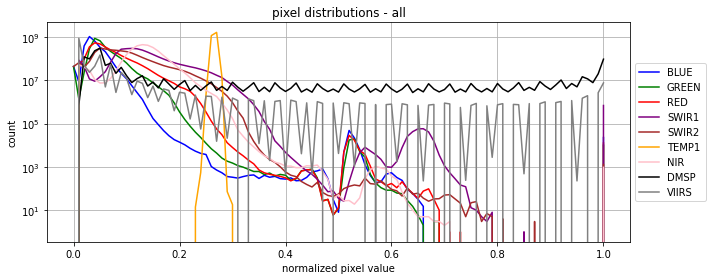

In [21]:
band_hists = np.sum(image_hists, axis=0, dtype=np.int64)  # shape [C, nbins]
plot_band_hists(
    band_hists,
    BAND_ORDER_NLSPLIT,
    band_colors=BAND_COLORS,
    bin_centers=BAND_BIN_CENTERS,
    xlabel='normalized pixel value',
    ylabel='count',
    title='pixel distributions - all',
    yscale='log')

In [30]:
features = image_hists
labels = labels
group_labels = group_labels
group_names = np.unique(group_labels)

In [31]:
N = len(labels)
assert len(features) == N
assert len(group_labels) == N

In [34]:
features.shape

(57195, 808)

In [17]:
image_hists[:, -2:, :].shape

(56776, 2, 101)

In [33]:
import scipy.spatial
import time
distance_metric = 'cityblock'
features = image_hists.reshape(len(image_hists), -1)

print('Pre-computing distance matrix...', end='')
start = time.time()
dists = scipy.spatial.distance.squareform(
    scipy.spatial.distance.pdist(features, metric=distance_metric)
)
elapsed = time.time() - start
print(f' took {elapsed:.2f} seconds.')

Pre-computing distance matrix... took 0.00 seconds.


In [20]:
print(f' took {elapsed:.2f} seconds.')

 took 1204.59 seconds.


In [30]:
group_names = 'ABCDE'
i = 0
cv_groups = [x for x in range(len(group_names)) if x != i]
test_groups = [i]

In [27]:
[x for x in range(len(group_names)) if x != model_fold]

NameError: name 'group_names' is not defined

In [31]:
cv_indices = np.isin(group_labels, cv_groups).nonzero()[0]
test_indices = np.isin(group_labels, test_groups).nonzero()[0]

In [34]:
dists_cv = dists[np.ix_(cv_indices, cv_indices)]
X = features[cv_indices]
y = labels[cv_indices]
groups = group_labels[cv_indices]
w = None

In [45]:
import sklearn.model_selection
ks = 2 ** np.arange(0, 11)  # 1 to 1024
preds = np.ones([len(ks), len(cv_indices)], dtype=np.float64) * np.nan
group_mses = np.ones([len(ks), len(cv_groups)], dtype=np.float64) * np.nan
leftout_group_labels = np.zeros(len(cv_groups), dtype=np.int32)
logo = sklearn.model_selection.LeaveOneGroupOut()

In [47]:
preds.shape

(11, 45420)

In [48]:
for g, (train_indices, val_indices) in enumerate(logo.split(X, groups=groups)):
    start = time.time()
    leftout_group_labels[g] = groups[val_indices[0]]

    train_X, train_y = X[train_indices], y[train_indices]
    val_y = y[val_indices]
    val_w = None if w is None else w[val_indices]

    # assign each unique input training value the same training label
    if len(train_X.shape) == 1:  # scalars
        u = np.unique(train_X)
        new_train_y = np.zeros_like(train_y)
        for value in u:
            mask = (train_X == value)
            new_train_y[mask] = np.mean(train_y[mask])
        train_y = new_train_y

    nearest_indices = np.argsort(dists_cv[np.ix_(val_indices, train_indices)], axis=1)
    
    for i, k in enumerate(ks):
        if len(train_indices) < k:
            break

        val_preds = np.mean(train_y[nearest_indices[:, :k]], axis=1)
        preds[i, val_indices] = val_preds[:,0]
        group_mses[i, g] = np.average((val_preds - val_y) ** 2, weights=val_w)

    elapsed = time.time() - start
    print(f' took {elapsed:.2f} seconds.')

 took 26.79 seconds.
 took 26.85 seconds.
 took 26.92 seconds.
 took 26.90 seconds.


In [50]:
mses = np.average((preds - y[:,0]) ** 2, axis=1, weights=w)  # shape [K]

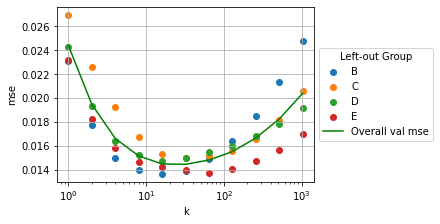

In [52]:
h = max(3, len(group_names) * 0.2)
fig, ax = plt.subplots(1, 1, figsize=(h*2, h), constrained_layout=True)
for g, group_label in enumerate(leftout_group_labels):
    group_name = group_names[group_label]
    ax.scatter(x=ks, y=group_mses[:, g], label=group_name)#,
               #c=[cm.tab20.colors[g % 20]])
ax.plot(ks, mses, 'g-', label='Overall val mse')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Left-out Group')
ax.set(xlabel='k', ylabel='mse')
ax.set_xscale('log')
ax.grid(True)
plt.show()

In [53]:
best_k = ks[np.argmin(mses)]

In [65]:
from sklearn.metrics import r2_score

# assign each unique input training value the same training label
if len(X.shape) == 1:  # scalars
    u = np.unique(X)
    new_y = np.zeros_like(y)
    for value in u:
        mask = (X == value)
        new_y[mask] = np.mean(y[mask])
    y = new_y

nearest_indices = np.argsort(dists[np.ix_(test_indices, cv_indices)], axis=1)
test_preds = np.mean(y[nearest_indices[:, :best_k]], axis=1)

best_val_mse = np.min(mses)
test_y = labels[test_indices]
test_w = None
test_mse = np.average((test_preds[:,0] - test_y[:,0]) ** 2, weights=test_w)
test_r2 = r2_score(test_y[:,0], test_preds[:,0])
print(f'best val mse: {best_val_mse:.3f}, best k: {best_k}, test mse: {test_mse:.3f}, test r2: {test_r2:.3f}')

best val mse: 0.014, best k: 32, test mse: 0.012, test r2: 0.591


In [61]:
test_mse = np.average((test_preds[:,0] - test_y[:,0]) ** 2)
print(f'best val mse: {best_val_mse:.3f}, best k: {best_k}, test mse: {test_mse:.3f}')

best val mse: 0.014, best k: 32, test mse: 0.012


In [63]:
from sklearn.metrics import r2_score
r2_score(test_y[:,0], test_preds[:,0])

0.5905471927542405

In [21]:
train_knn_logo_opt(
    dists=dists,
    features=features,
    labels=labels,
    group_labels=group_labels,
    cv_groups=[x for x in range(len(group_names)) if x != i],
    test_groups=[i],
    weights=weights,
    plot=do_plot,
    group_names=group_names)

(56776, 56776)

In [13]:
def train_knn_logo_opt(dists, features, labels, group_labels, cv_groups, test_groups,
                       weights=None, plot=True, group_names=None):
    '''Leave-one-group-out cross-validated training of a KNN model.
    Similar to train_knn_logo(), but uses a pre-computed distance matrix.
    Args
    - dists: np.array, shape [N, N], precomputed distance matrix
    - features: np.array, shape [N, D]
    - labels: np.array, shape [N]
    - group_labels: np.array, shape [N], type np.int32
    - cv_groups: list of int, labels of groups to use for LOGO-CV
    - test_groups: list of int, labels of groups to test on
    - weights: np.array, shape [N]
    - plot: bool, whether to plot MSE as a function of k
    - group_names: list of str, names of the groups, only used when plotting
    Returns
    - test_preds: np.array, predictions on indices from test_groups
    '''
    cv_indices = np.isin(group_labels, cv_groups).nonzero()[0]
    test_indices = np.isin(group_labels, test_groups).nonzero()[0]

    dists_cv = dists[np.ix_(cv_indices, cv_indices)]
    X = features[cv_indices]
    y = labels[cv_indices]
    groups = group_labels[cv_indices]
    w = None if weights is None else weights[cv_indices]

    ks = 2 ** np.arange(0, 11)  # 1 to 1024
    preds = np.ones([len(ks), len(cv_indices)], dtype=np.float64) * np.nan
    group_mses = np.ones([len(ks), len(cv_groups)], dtype=np.float64) * np.nan
    leftout_group_labels = np.zeros(len(cv_groups), dtype=np.int32)
    logo = sklearn.model_selection.LeaveOneGroupOut()

    for g, (train_indices, val_indices) in enumerate(logo.split(X, groups=groups)):
        leftout_group_labels[g] = groups[val_indices[0]]

        train_X, train_y = X[train_indices], y[train_indices]
        val_y = y[val_indices]
        val_w = None if w is None else w[val_indices]

        # assign each unique input training value the same training label
        if len(train_X.shape) == 1:  # scalars
            u = np.unique(train_X)
            new_train_y = np.zeros_like(train_y)
            for value in u:
                mask = (train_X == value)
                new_train_y[mask] = np.mean(train_y[mask])
            train_y = new_train_y

        nearest_indices = np.argsort(dists_cv[np.ix_(val_indices, train_indices)], axis=1)

        for i, k in enumerate(ks):
            if len(train_indices) < k:
                break

            val_preds = np.mean(train_y[nearest_indices[:, :k]], axis=1)
            preds[i, val_indices] = val_preds
            group_mses[i, g] = np.average((val_preds - val_y) ** 2, weights=val_w)

    mses = np.average((preds - y) ** 2, axis=1, weights=w)  # shape [K]

    if plot:
        h = max(3, len(group_names) * 0.2)
        fig, ax = plt.subplots(1, 1, figsize=(h*2, h), constrained_layout=True)
        for g, group_label in enumerate(leftout_group_labels):
            group_name = group_names[group_label]
            ax.scatter(x=ks, y=group_mses[:, g], label=group_name,
                       c=[cm.tab20.colors[g % 20]])
        ax.plot(ks, mses, 'g-', label='Overall val mse')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Left-out Group')
        ax.set(xlabel='k', ylabel='mse')
        ax.set_xscale('log')
        ax.grid(True)
        plt.show()

    best_k = ks[np.argmin(mses)]

    # assign each unique input training value the same training label
    if len(X.shape) == 1:  # scalars
        u = np.unique(X)
        new_y = np.zeros_like(y)
        for value in u:
            mask = (X == value)
            new_y[mask] = np.mean(y[mask])
        y = new_y

    nearest_indices = np.argsort(dists[np.ix_(test_indices, cv_indices)], axis=1)
    test_preds = np.mean(y[nearest_indices[:, :best_k]], axis=1)

    best_val_mse = np.min(mses)
    test_y = labels[test_indices]
    test_w = None if weights is None else weights[test_indices]
    test_mse = np.average((test_preds - test_y) ** 2, weights=test_w)
    print(f'best val mse: {best_val_mse:.3f}, best k: {best_k}, test mse: {test_mse:.3f}')
    return test_preds


def knn_cv_opt(features, labels, group_labels, group_names, savedir=None, weights=None,
               do_plot=False, subset_indices=None, subset_name=None, save_dict=None,
               distance_metric='cityblock'):
    '''Similar to knn_cv(), but pre-computes a distance matrix to use for all folds.
    For every fold F (the test fold):
      1. uses leave-one-fold-out CV on all other folds
         to tune KNN k parameter
      2. using best k, trains KNN model on all folds except F
      3. runs trained ridge model on F
    Saves predictions for each fold on test.
        savedir/test_preds_{subset_name}.npz if subset_name is given
        savedir/test_preds.npz otherwise
    Args
    - features: np.array, shape [N, D]
    - labels: np.array, shape [N]
    - group_labels: np.array, shape [N], type int
    - group_names: list of str, a group_label of X corresponds to group_names[X]
    - savedir: str, path to directory to save predictions
    - weights: np.array, shape [N], optional
    - do_plot: bool, whether to plot alpha vs. mse curve for 1st fold
    - subset_indices: np.array, indices of examples to include for both
        training and testing
    - subset_name: str, name of the subset
    - save_dict: dict, str => np.array, saved with test preds npz file
    - distance_metric: str, see documentation for scipy.spatial.distance.pdist
    Returns
    - test_preds: np.array, shape [N]
    '''
    N = len(labels)
    assert len(features) == N
    assert len(group_labels) == N

    if save_dict is None:
        save_dict = {}
    else:
        save_dict = dict(save_dict)  # make a copy

    if subset_indices is None:
        assert subset_name is None
        filename = 'test_preds.npz'
    else:
        assert subset_name is not None
        features = features[subset_indices]
        labels = labels[subset_indices]
        group_labels = group_labels[subset_indices]

        filename = f'test_preds_{subset_name}.npz'
        for key in save_dict:
            save_dict[key] = save_dict[key][subset_indices]

    if savedir is not None:
        npz_path = os.path.join(savedir, filename)
        assert not os.path.exists(npz_path)

    print('Pre-computing distance matrix...', end='')
    start = time.time()
    dists = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(features, metric=distance_metric)
    )
    elapsed = time.time() - start
    print(f' took {elapsed:.2f} seconds.')

    test_preds = np.zeros_like(labels, dtype=np.float32)
    for i, f in enumerate(group_names):
        print('Group:', f)
        test_mask = (group_labels == i)
        if np.sum(test_mask) == 0:
            print(f'no examples corresponding to group {f} were found')
            continue
        test_preds[test_mask] = train_knn_logo_opt(
            dists=dists,
            features=features,
            labels=labels,
            group_labels=group_labels,
            cv_groups=[x for x in range(len(group_names)) if x != i],
            test_groups=[i],
            weights=weights,
            plot=do_plot,
            group_names=group_names)

        # only plot the curve for the first group
        do_plot = False

    evaluate(labels=labels, preds=test_preds, weights=weights, do_print=True, title='Pooled test preds')

    # save preds on the test set
    if savedir is not None:
        os.makedirs(savedir, exist_ok=True)

        # build up save_dict
        if 'labels' in save_dict:
            assert np.array_equal(labels, save_dict['labels'])
        save_dict['labels'] = labels
        if weights is not None:
            save_dict['weights'] = weights
        save_dict['test_preds'] = test_preds

        print('saving test preds to:', npz_path)
        np.savez_compressed(npz_path, **save_dict)

    return test_preds

In [ ]:


knn_cv_opt(features, labels, group_labels, group_names, savedir=None, weights=None,
               do_plot=False, subset_indices=None, subset_name=None, save_dict=None,
               distance_metric='cityblock')

In [28]:
X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

In [ ]:
class CustomCrossValidation:
    
    @classmethod
    def split(cls,
              X: pd.DataFrame,
              y: np.ndarray = None,
              i_list: list = None):
        """Returns crossvalidation from i_list"""
        for i, test in enumerate(i_list):
            training_indices = 
            training_group = group_idx
            # Gets the next group right after
            # the training as test
            test_group = group_idx + 1
            training_indices = np.where(
                groups == training_group)[0]
            test_indices = np.where(groups == test_group)[0]
            if len(test_indices) > 0:
                # Yielding to training and testing indices
                # for cross-validation generator
                yield training_indices, test_indices

In [23]:
X.shape

(45420, 808)

In [22]:
i_list

[array([    0,     2,     6, ..., 57172, 57176, 57181], dtype=int32),
 array([    4,     7,     8, ..., 57179, 57183, 57186], dtype=int32),
 array([   13,    31,    66, ..., 57189, 57193, 57194], dtype=int32),
 array([    5,    10,    14, ..., 57185, 57190, 57192], dtype=int32)]

In [48]:
#KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold

rf_params = {
    'n_neighbors': 2 ** np.arange(0, 11)
}
logo = LeaveOneGroupOut()
clf = KNeighborsRegressor()
grid = GridSearchCV(clf, rf_params, cv=logo.split(X, y, groups), scoring='r2')
grid.fit(X, y)
print(grid.best_params_)
print("MSE:"+ str(grid.best_score_))

{'n_neighbors': 32}
MSE:0.5794904416162027


In [47]:
2 ** np.arange(0, 11)

array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])

In [31]:
import scipy
import time
distance_metric = 'cityblock'

start = time.time()
dists = scipy.spatial.distance.squareform(
    scipy.spatial.distance.pdist(X, metric=distance_metric)
)
elapsed = time.time() - start
print(f' took {elapsed:.2f} seconds.')

 took 579.48 seconds.


In [40]:
from sklearn.model_selection import LeaveOneGroupOut

ks = 2 ** np.arange(0, 11)  # 1 to 1024
preds = np.ones([len(ks), len(y)], dtype=np.float64) * np.nan
#group_mses = np.ones([len(ks), len(groups)], dtype=np.float64) * np.nan
#leftout_group_labels = np.zeros(len(cv_groups), dtype=np.int32)
logo = LeaveOneGroupOut()

In [44]:
for i, k in enumerate(ks):
    model = KNeighborsRegressor(k, metric=distance_metric)

    for g, (train_indices, val_indices) in enumerate(logo.split(X, groups=groups)):
        if len(train_indices) < k:
            break
        print('train:', train_indices)
        print('val:', val_indices)
        train_X, val_X = X[train_indices], X[val_indices]
        train_y, val_y = y[train_indices], y[val_indices]
        
        nearest_indices = np.argsort(dists[np.ix_(val_indices, train_indices)], axis=1)
        print(nearest_indices)
        '''
        # assign each unique input training value the same training label
        model.fit(X=train_X, y=train_y)
        val_preds = model.predict(val_X)
        preds[i, val_indices] = val_preds
        group_mses[i, g] = np.average((val_preds - val_y) ** 2, weights=val_w)
        leftout_group_labels[g] = groups[val_indices[0]]
        '''
    print(7/0)

train: [11355 11356 11357 ... 45417 45418 45419]
val: [    0     1     2 ... 11352 11353 11354]


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut

ks = 2 ** np.arange(0, 11)  # 1 to 1024
preds = np.ones([len(ks), len(cv_indices)], dtype=np.float64) * np.nan
group_mses = np.ones([len(ks), len(cv_groups)], dtype=np.float64) * np.nan
leftout_group_labels = np.zeros(len(cv_groups), dtype=np.int32)
logo = LeaveOneGroupOut()

In [ ]:
for g, (train_indices, val_indices) in enumerate(logo.split(X, groups=groups)):
    leftout_group_labels[g] = groups[val_indices[0]]

    train_X, train_y = X[train_indices], y[train_indices]
    val_y = y[val_indices]

    # # assign each unique input training value the same training label
    # if len(train_X.shape) == 1:  # scalars
    #     u = np.unique(train_X)
    #     new_train_y = np.zeros_like(train_y)
    #     for value in u:
    #         mask = (train_X == value)
    #         new_train_y[mask] = np.mean(train_y[mask])
    #     train_y = new_train_y

    nearest_indices = np.argsort(dists_cv[np.ix_(val_indices, train_indices)], axis=1)

    for i, k in enumerate(ks):
        if len(train_indices) < k:
            break

        val_preds = np.mean(train_y[nearest_indices[:, :k]], axis=1)
        preds[i, val_indices] = val_preds
        group_mses[i, g] = np.average((val_preds - val_y) ** 2, weights=val_w)